In [74]:
import sys
import os
import time
import logging
import datetime
from datetime import datetime, timedelta
import yaml
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import requests
import pandas_gbq
from dreams_core.googlecloud import GoogleCloud as dgc
from dreams_core import core as dc
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema


# import local files if necessary
sys.path.append('..//src')
import training_data as td
importlib.reload(td)

# load dotenv
load_dotenv()

# configure logger
logger = dc.setup_logger()
logger.setLevel(logging.DEBUG)

# Custom format function for displaying numbers
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')


def load_config(file_path='config.yaml'):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
config = load_config()


#### Load the datasets

In [80]:
importlib.reload(td)
config = load_config()


# retrieve prices data
if 'prices_filled_df' not in locals():
    prices_df = td.retrieve_prices_data()

    # fill gaps in prices data
    prices_df,prices_outcomes_df = td.fill_prices_gaps(prices_df,config['data_cleaning']['max_gap_days'])
logger.info(f"Prices data shape: {prices_df.shape}")


# Retrieve or load transfers data
# if 'transfers_df' not in locals():
transfers_df = td.retrieve_transfers_data(
    config['modeling']['training_period_start'],
    config['modeling']['modeling_period_start'],
    config['modeling']['modeling_period_end']
    )
logger.info(f"Transfers data shape: {transfers_df.shape}")


# Calculate and clean profits data
profits_df = td.prepare_profits_data(transfers_df, prices_df)
profits_df = td.calculate_wallet_profitability(profits_df)
profits_df,_ = td.clean_profits_df(profits_df, config['data_cleaning']['profitability_filter'])
logger.info(f"Profits data shape: {profits_df.shape}")

profits_df.head()

[09/Sep/2024 12:13:46] INFO [dreams_core.core.retrieve_prices_data:34] retrieving prices data...
[09/Sep/2024 12:13:48] INFO [dreams_core.core.fill_prices_gaps:123] retained 401 coins.
[09/Sep/2024 12:13:48] INFO [dreams_core.core.fill_prices_gaps:124] 382 coins had no gaps, 19 coins had gaps filled, and 38 coins were dropped due to large gaps.
[09/Sep/2024 12:13:48] INFO [dreams_core.core.<module>:11] Prices data shape: (110929, 3)
[09/Sep/2024 12:13:48] INFO [dreams_core.core.retrieve_transfers_data:330] retrieving transfers data...
[09/Sep/2024 12:14:08] INFO [dreams_core.core.retrieve_transfers_data:337] retrieved transfers_df with shape (12885534, 5) after 19.6 seconds.
[09/Sep/2024 12:14:08] INFO [dreams_core.core.<module>:21] Transfers data shape: (12885534, 5)
[09/Sep/2024 12:14:08] INFO [dreams_core.core.prepare_profits_data:378] Preparing profits_df data...
[09/Sep/2024 12:14:10] DEBUG [dreams_core.core.prepare_profits_data:398] <Step 1> merge transfers and prices: 2.48 secon

,coin_id,wallet_address,date,net_transfers,balance,price,profits_change,profits_cumulative,usd_balance,usd_net_transfers,usd_inflows,usd_inflows_cumulative,total_return
0,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-23,5.2e-08,5.2e-08,1.88983550773,0,0,9.82714464018e-08,9.82714464018e-08,9.82714464018e-08,9.82714464018e-08,0
1,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-28,0.002920722,0.002920774,7.47303212902,2.90326224307e-07,2.90326224307e-07,0.0218270379436,0.0218266493459,0.0218266493459,0.0218267476174,1.33013964974e-05
2,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-31,0,0.002920774,27.5991647724,0.0587838849452,0.0587841752714,0.0806109228888,0,0,0.0218267476174,2.69321734515
3,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000000004685666c7653cc148f566f0511901b37,2024-03-13,2.38776413,2.38776413,2.20442838263,0,0,5.26365501921,5.26365501921,5.26365501921,5.26365501921,0
4,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000000004685666c7653cc148f566f0511901b37,2024-03-31,0,2.38776413,27.5991647724,60.6366406422,60.6366406422,65.9002956614,0,0,5.26365501921,11.5198736279


In [93]:
def price_data_transfers_df():
    """
    Create a sample transfers DataFrame for testing interactions with price data.
    """
    data = {
        'coin_id': ['BTC', 'BTC', 'MYRO', 'MYRO'],
        'wallet_address': ['wallet1', 'wallet1', 'wallet2', 'wallet2'],
        'date': [
            '2023-03-01', '2023-04-01',  # BTC wallet1 buys during training period
            '2023-02-20', '2023-03-10'   # MYRO wallet2 buys during training period (before price data)
        ],
        'net_transfers': [10.0, -10.0, 1000.0, -1000.0],  # Buys and sells
        'balance': [10.0, 0.0, 1000.0, 0.0]  # Balance adjustments after buy and sell
    }
    df = pd.DataFrame(data)
    df['coin_id'] = df['coin_id'].astype('category')
    df['date'] = pd.to_datetime(df['date'])
    return df

def price_data_prices_df():
    """
    Create a sample prices DataFrame for testing interactions with price data.
    """
    data = {
        'date': ['2023-03-15', '2023-04-01', '2023-03-15', '2023-04-01'],
        'coin_id': ['BTC', 'BTC', 'MYRO', 'MYRO'],
        'price': [22000.0, 23000, 12, 15]  # Price data available starting from 2023-03-15
    }
    df = pd.DataFrame(data)
    df['coin_id'] = df['coin_id'].astype('category')
    df['date'] = pd.to_datetime(df['date'])
    return df

price_data_transfers_df = price_data_transfers_df()
price_data_prices_df = price_data_prices_df()


profits_df = td.prepare_profits_data(price_data_transfers_df, price_data_prices_df)
result = td.calculate_wallet_profitability(profits_df)

# Test scenario: Buy during training period before price data, sell after price data
wallet1_btc = result[(result['wallet_address'] == 'wallet1') & (result['coin_id'] == 'BTC')]
wallet1_btc_profits = (23000-22000) * 10
assert wallet1_btc.iloc[0]['date'] == pd.Timestamp('2023-03-15')  # First row should reflect earliest price data
assert wallet1_btc.iloc[0]['profits_cumulative'] == 0  # No profit on initial transfer in
assert wallet1_btc.iloc[1]['profits_cumulative'] == wallet1_btc_profits  # Profitability calculation should be valid

# # Test scenario: Buy and sell before price data is available
# wallet2_myro = result[(result['wallet_address'] == 'wallet2') & (result['coin_id'] == 'MYRO')]
# assert wallet2_myro.empty  # No rows should exist, as no price data was available for the transaction



[09/Sep/2024 12:56:00] INFO [dreams_core.core.prepare_profits_data:378] Preparing profits_df data...
[09/Sep/2024 12:56:00] DEBUG [dreams_core.core.prepare_profits_data:398] <Step 1> merge transfers and prices: 0.00 seconds
[09/Sep/2024 12:56:00] DEBUG [dreams_core.core.prepare_profits_data:413] <Step 2> identify first prices of coins: 0.01 seconds
[09/Sep/2024 12:56:00] DEBUG [dreams_core.core.prepare_profits_data:437] <Step 3> created new records as of the first_price_date: 0.00 seconds
[09/Sep/2024 12:56:00] DEBUG [dreams_core.core.prepare_profits_data:451] <Step 4> merge new records into profits_df: 0.00 seconds
[09/Sep/2024 12:56:00] DEBUG [dreams_core.core.prepare_profits_data:468] <Step 5> removed records prior to each wallet's first token inflows: 0.00 seconds
[09/Sep/2024 12:56:00] INFO [dreams_core.core.calculate_wallet_profitability:521] Starting generation of profits_df...
[09/Sep/2024 12:56:00] DEBUG [dreams_core.core.calculate_wallet_profitability:533] Offset prices and b

,coin_id,wallet_address,date,net_transfers,balance,price,profits_change,profits_cumulative,usd_balance,usd_net_transfers,usd_inflows,usd_inflows_cumulative,total_return
0,BTC,wallet1,2023-03-15,10,10,22000,0,0,220000,220000,220000,220000,0
1,BTC,wallet1,2023-04-01,-10,0,23000,10000,10000,0,-230000,0,220000,0.0454545454545


In [ ]:
transfers_df[transfers_df['date']<TRAINING_PERIOD_START]

In [90]:
edge_case_transfers_df

,coin_id,wallet_address,date,net_transfers,balance
0,BTC,wallet1,2023-01-01,10,10
1,BTC,wallet1,2023-02-01,-10,0
2,BTC,wallet2,2023-04-01,5,5
3,BTC,wallet2,2023-05-01,-5,0
4,ETH,wallet1,2023-02-01,100,100
5,ETH,wallet1,2023-03-01,-50,50
6,ETH,wallet2,2023-04-01,25,75
7,ETH,wallet2,2023-05-01,-25,0
8,MYRO,wallet3,2023-02-01,1000,1000
9,MYRO,wallet3,2023-02-15,-500,500


In [89]:
result[(result['wallet_address'] == 'wallet1') & (result['coin_id'] == 'BTC')]

,coin_id,wallet_address,date,net_transfers,balance,price,profits_change,profits_cumulative,usd_balance,usd_net_transfers,usd_inflows,usd_inflows_cumulative,total_return
0,BTC,wallet1,2023-01-01,10,10,20000,0,0,200000,200000,200000,200000,0
1,BTC,wallet1,2023-02-01,-10,0,21000,10000,10000,0,-210000,0,200000,0.05


In [ ]:



# Case 1: Buy and sell before training, then buy/sell during training
wallet1_btc = result[(result['wallet_address'] == 'wallet1') & (result['coin_id'] == 'BTC')]
assert wallet1_btc.iloc[0]['date'] == pd.Timestamp('2023-04-01')  # First row is during training period

# # Case 2: Buy before training, sell some before training
# wallet1_eth = result[(result['wallet_address'] == 'wallet1') & (result['coin_id'] == 'ETH')]
# assert wallet1_eth.iloc[0]['date'] == pd.Timestamp('2023-03-01')  # Transfer in on training period start

# # Case 3: Buy and sell all before training
# wallet2_btc = result[(result['wallet_address'] == 'wallet2') & (result['coin_id'] == 'BTC')]
# assert wallet2_btc.empty  # No rows should exist

# # Case 4: Buy before training, sell all during training
# wallet2_eth = result[(result['wallet_address'] == 'wallet2') & (result['coin_id'] == 'ETH')]
# assert wallet2_eth.iloc[0]['date'] == pd.Timestamp('2023-03-01')  # Transfer in on training period start

# # Case 5: Buy during training before price data, sell all during training after price data
# wallet3_myro = result[(result['wallet_address'] == 'wallet3') & (result['coin_id'] == 'MYRO')]
# assert wallet3_myro.iloc[0]['date'] == pd.Timestamp('2023-03-15')  # First price data available

# # Case 6: Buy and sell all during training before price data
# wallet3_eth = result[(result['wallet_address'] == 'wallet3') & (result['coin_id'] == 'ETH')]
# assert wallet3_eth.empty  # No rows should exist due to no price data




In [18]:
# profits_df = profits_df_full.copy()

logger.info("Starting generation of profits_df...")
start_time = time.time()

# Raise an error if there are any missing prices
if profits_df['price'].isnull().any():
    raise ValueError("Missing prices found for some transfer dates. This indicates an issue with the price data generation.")

# create offset price and balance rows to easily calculate changes between periods
profits_df['previous_price'] = profits_df.groupby(['coin_id', 'wallet_address'],observed=True)['price'].shift(1)
profits_df['previous_price'] = profits_df['previous_price'].fillna(profits_df['price'])
profits_df['previous_balance'] = profits_df.groupby(['coin_id', 'wallet_address'],observed=True)['balance'].shift(1).fillna(0)

logger.debug(f"Offset prices and balances for profitability logic: {time.time() - start_time:.2f} seconds")
step_time = time.time()

# calculate the profitability change in each period and sum them to get cumulative profitability
profits_df['profits_change'] = (profits_df['price'] - profits_df['previous_price']) * profits_df['previous_balance']
profits_df['profits_cumulative'] = profits_df.groupby(['coin_id', 'wallet_address'],observed=True)['profits_change'].cumsum()

logger.debug(f"Calculate profitability: {time.time() - step_time:.2f} seconds")
step_time = time.time()

# Calculate USD inflows, balances, and rate of return
profits_df['usd_balance'] = profits_df['balance'] * profits_df['price']
profits_df['usd_net_transfers'] = profits_df['net_transfers'] * profits_df['price']
profits_df['usd_inflows'] = profits_df['usd_net_transfers'].where(profits_df['usd_net_transfers'] > 0, 0)
profits_df['usd_inflows_cumulative'] = profits_df.groupby(['coin_id', 'wallet_address'],observed=True)['usd_inflows'].cumsum()
profits_df['total_return'] = profits_df['profits_cumulative'] / profits_df['usd_inflows_cumulative'].where(profits_df['usd_inflows_cumulative'] != 0, np.nan)

# logger.debug(f"Calculate rate of return {time.time() - step_time:.2f} seconds")
# step_time = time.time()

# # Drop helper columns
# profits_df.drop(columns=['previous_price', 'previous_balance'], inplace=True)

# total_time = time.time() - start_time
# logger.info(f"Generated profits df after {total_time:.2f} seconds")

profits_df.isna().sum()


[09/Sep/2024 10:19:25] INFO [dreams_core.core.<module>:3] Starting generation of profits_df...
[09/Sep/2024 10:19:32] DEBUG [dreams_core.core.<module>:15] Offset prices and balances for profitability logic: 6.29 seconds
[09/Sep/2024 10:19:35] DEBUG [dreams_core.core.<module>:22] Calculate profitability: 3.09 seconds


coin_id                         0
wallet_address                  0
date                            0
net_transfers                   0
balance                         0
price                           0
previous_price                  0
previous_balance                0
profits_change                  0
profits_cumulative              0
usd_balance                     0
usd_net_transfers               0
usd_inflows                     0
usd_inflows_cumulative          0
total_return              1025489
dtype: int64

In [65]:
profits_df['transfer_sequence'] = profits_df.groupby(['coin_id', 'wallet_address'])['date'].rank(method='first', ascending=True).astype(int)


transfer_sequence_counts = profits_df.groupby('transfer_sequence').size().reset_index(name='count')
transfer_sequence_counts_sorted = transfer_sequence_counts.sort_values(by='transfer_sequence', ascending=True)


transfer_sequence_counts_sorted


# Group by transfer_sequence and count NaN values in total_return
nan_counts = profits_df.groupby('transfer_sequence')['total_return'].apply(lambda x: x.isna().sum()).reset_index(name='nan_count')

# Merge the counts of NaN values with the original transfer_sequence_counts
transfer_sequence_counts_sorted = transfer_sequence_counts_sorted.merge(nan_counts, on='transfer_sequence')

transfer_sequence_counts_sorted


,transfer_sequence,count,nan_count
0,1,2411754,27842
1,2,2366606,7246
2,3,1897934,5784
3,4,1061591,2410
4,5,462757,812
...,...,...,...
308,309,77,0
309,310,70,0
310,311,65,0
311,312,61,0


In [70]:
importlib.reload(td)
config = load_config()


# Calculate and clean profits data
profits_df = td.prepare_profits_data(transfers_df, prices_df)
profits_df = td.calculate_wallet_profitability(profits_df)
profits_df,_ = td.clean_profits_df(profits_df, config['data_cleaning']['profitability_filter'])
logger.info(f"Profits data shape: {profits_df.shape}")

[09/Sep/2024 12:09:46] INFO [dreams_core.core.prepare_profits_data:378] Preparing profits_df data...
[09/Sep/2024 12:09:49] DEBUG [dreams_core.core.prepare_profits_data:398] <Step 1> merge transfers and prices: 2.94 seconds
[09/Sep/2024 12:09:51] DEBUG [dreams_core.core.prepare_profits_data:413] <Step 2> identify first prices of coins: 2.34 seconds
[09/Sep/2024 12:09:52] DEBUG [dreams_core.core.prepare_profits_data:437] <Step 3> created new records as of the first_price_date: 1.25 seconds
[09/Sep/2024 12:09:59] DEBUG [dreams_core.core.prepare_profits_data:451] <Step 4> merge new records into profits_df: 6.89 seconds
[09/Sep/2024 12:10:03] DEBUG [dreams_core.core.prepare_profits_data:467] <Step 5> removed records prior to each wallet's first token inflows: 3.42 seconds
[09/Sep/2024 12:10:03] INFO [dreams_core.core.calculate_wallet_profitability:520] Starting generation of profits_df...
[09/Sep/2024 12:10:08] DEBUG [dreams_core.core.calculate_wallet_profitability:532] Offset prices and b

In [73]:
# profits_df.isna().count()

profits_df.head()

,index,coin_id,wallet_address,date,net_transfers,balance,first_balance_date,price,profits_change,profits_cumulative,usd_balance,usd_net_transfers,usd_inflows,usd_inflows_cumulative,total_return
0,0,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-23,5.2e-08,5.2e-08,NaT,1.88983550773,0,0,9.82714464018e-08,9.82714464018e-08,9.82714464018e-08,9.82714464018e-08,0
1,1,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-28,0.002920722,0.002920774,NaT,7.47303212902,2.90326224307e-07,2.90326224307e-07,0.0218270379436,0.0218266493459,0.0218266493459,0.0218267476174,1.33013964974e-05
2,2,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-31,0,0.002920774,NaT,27.5991647724,0.0587838849452,0.0587841752714,0.0806109228888,0,0,0.0218267476174,2.69321734515
3,NaN,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000000004685666c7653cc148f566f0511901b37,2024-03-13,2.38776413,2.38776413,NaT,2.20442838263,0,0,5.26365501921,5.26365501921,5.26365501921,5.26365501921,0
4,4,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000000004685666c7653cc148f566f0511901b37,2024-03-31,0,2.38776413,2024-03-12,27.5991647724,60.6366406422,60.6366406422,65.9002956614,0,0,5.26365501921,11.5198736279


In [62]:
c = 'f0420cea-5dc1-42ac-b1bc-f6e48b7804f1'
w = '0x3f01ebc349d868473f5e698c0dba7cd683ff3c0e'

# c = '39009e7c-3209-415b-a9a7-76b60d908758'
# w = '0x90e344a8c96ea2e0842fb8c1b4c850b576a533f7'

# c = 'eac561a7-88ef-47a1-bc2e-d02e3b0d106f'
# w = '0x8e32ec2d5f41fa99fc9a04bd613328ec5f43743a'

profits_df[
    (profits_df['coin_id']==c) &
    (profits_df['wallet_address']==w)
]
# transfers_df[
#     (transfers_df['coin_id']==c) &
#     (transfers_df['wallet_address']==w)
# ]

,level_0,index,coin_id,wallet_address,date,net_transfers,balance,first_balance_date,price,profits_change,profits_cumulative,usd_balance,usd_net_transfers,usd_inflows,usd_inflows_cumulative,total_return


In [63]:
profits_df_full[
    (profits_df_full['coin_id']==c) &
    (profits_df_full['wallet_address']==w)
]

,coin_id,wallet_address,date,net_transfers,balance,price
10997508,f0420cea-5dc1-42ac-b1bc-f6e48b7804f1,0x3f01ebc349d868473f5e698c0dba7cd683ff3c0e,2023-05-25,0,0,0.205913846949
10997509,f0420cea-5dc1-42ac-b1bc-f6e48b7804f1,0x3f01ebc349d868473f5e698c0dba7cd683ff3c0e,2024-02-29,0,0,0.37144066046
10997510,f0420cea-5dc1-42ac-b1bc-f6e48b7804f1,0x3f01ebc349d868473f5e698c0dba7cd683ff3c0e,2024-03-31,0,0,0.608684990131


In [51]:
transfers_df[
    (transfers_df['coin_id']==c) &
    (transfers_df['wallet_address']==w)
]

,index,coin_id,wallet_address,date,net_transfers,balance,first_balance_date
11774067,11774067,eac561a7-88ef-47a1-bc2e-d02e3b0d106f,0x8e32ec2d5f41fa99fc9a04bd613328ec5f43743a,2023-03-06,2015.301,2015.301,2023-03-06
11774068,11774068,eac561a7-88ef-47a1-bc2e-d02e3b0d106f,0x8e32ec2d5f41fa99fc9a04bd613328ec5f43743a,2023-03-09,-1511.47575,503.82525,2023-03-06
11774069,11774069,eac561a7-88ef-47a1-bc2e-d02e3b0d106f,0x8e32ec2d5f41fa99fc9a04bd613328ec5f43743a,2023-03-11,1447.43932318,1951.26457318,2023-03-06
11774070,11774070,eac561a7-88ef-47a1-bc2e-d02e3b0d106f,0x8e32ec2d5f41fa99fc9a04bd613328ec5f43743a,2023-03-14,-1951.26457318,-2.27373675443e-13,2023-03-06
11774071,11774071,eac561a7-88ef-47a1-bc2e-d02e3b0d106f,0x8e32ec2d5f41fa99fc9a04bd613328ec5f43743a,2024-02-29,0,-2.27373675443e-13,2023-03-06
11774072,11774072,eac561a7-88ef-47a1-bc2e-d02e3b0d106f,0x8e32ec2d5f41fa99fc9a04bd613328ec5f43743a,2024-03-31,0,-2.27373675443e-13,2023-03-06


In [3]:
importlib.reload(td)
config = load_config()

sharks_coins_df = td.classify_shark_coins(profits_df, config['modeling'])
shark_wallets_df = td.classify_shark_wallets(sharks_coins_df,config['modeling'])

[09/Sep/2024 10:06:25] INFO [dreams_core.core.classify_shark_coins:602] identifying shark wallets...


[09/Sep/2024 10:06:31] INFO [dreams_core.core.classify_shark_coins:633] creation of sharks_df complete.


In [ ]:
shark_wallets_df['wallet_address']

In [80]:
importlib.reload(td)
config = load_config()

# only look at transfers during the modeling period
modeling_period_transfers_df = transfers_df[
    (transfers_df['date'] >= config['modeling']['training_period_end']) &
    (transfers_df['date'] <= config['modeling']['modeling_period_end'])
]

# only include wallets that meet the sharks criteria
modeling_period_transfers_df = modeling_period_transfers_df[
    modeling_period_transfers_df['wallet_address'].isin(shark_wallets_df['wallet_address'])
]

# generate a version of profits_df for only the modeling period
modeling_period_profits_data_df = td.prepare_profits_data(modeling_period_transfers_df, prices_df)
modeling_period_profits_df = td.calculate_wallet_profitability(modeling_period_profits_data_df)


modeling_period_profits_df.head()

[09/Sep/2024 02:29:05] INFO [dreams_core.core.prepare_profits_data:378] Preparing profits_df data...
[09/Sep/2024 02:29:05] DEBUG [dreams_core.core.prepare_profits_data:398] <Step 1> merge transfers and prices: 0.13 seconds
[09/Sep/2024 02:29:05] DEBUG [dreams_core.core.prepare_profits_data:413] <Step 2> identify first prices of coins: 0.12 seconds
[09/Sep/2024 02:29:05] DEBUG [dreams_core.core.prepare_profits_data:436] <Step 3> created new records as of the first_price_date: 0.02 seconds
[09/Sep/2024 02:29:06] DEBUG [dreams_core.core.prepare_profits_data:452] <Step 4> merge new records into profits_df: 0.35 seconds
[09/Sep/2024 02:29:06] INFO [dreams_core.core.calculate_wallet_profitability:495] Starting generation of profits_df...
[09/Sep/2024 02:29:06] DEBUG [dreams_core.core.calculate_wallet_profitability:507] Offset prices and balances for profitability logic: 0.31 seconds
[09/Sep/2024 02:29:06] DEBUG [dreams_core.core.calculate_wallet_profitability:514] Calculate profitability: 0

,coin_id,wallet_address,date,net_transfers,balance,price,profits_change,profits_cumulative,usd_balance,usd_net_transfers,usd_inflows,usd_total_inflows,total_return
0,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000a991c429ee2ec6df19d40fe0c80088b8,2024-03-13,216.04104,216.04104,2.20442838263,0,0,476.24700039,476.24700039,476.24700039,476.24700039,0
1,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000a991c429ee2ec6df19d40fe0c80088b8,2024-03-31,0,216.04104,27.5991647724,5486.30526016,5486.30526016,5962.55226055,0,0,476.24700039,11.5198736279
2,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x003b2bbe004a21fe97b0ba53de861aa554199659,2024-03-18,163.765230252,163.765230252,2.02777462689,0,0,332.078978672,332.078978672,332.078978672,332.078978672,0
3,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x003b2bbe004a21fe97b0ba53de861aa554199659,2024-03-19,226.517768096,390.282998348,1.71456030181,-51.2936160648,-51.2936160648,669.163735439,388.378372832,388.378372832,720.457351504,-0.0711959090399
4,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x003b2bbe004a21fe97b0ba53de861aa554199659,2024-03-23,348.764463228,739.047461576,1.88983550773,68.4069329006,17.1133168358,1396.67813478,659.107466441,659.107466441,1379.56481795,0.0124048660949


In [ ]:
# 1. Format dataframes and merge on 'coin_id' and 'date'
# ----------------------------------------------------------
# set dates to datetime and coin_ids to categorical
transfers_df = transfers_df.copy()
prices_df = prices_df.copy()

transfers_df['date'] = pd.to_datetime(transfers_df['date'])
prices_df['date'] = pd.to_datetime(prices_df['date'])
transfers_df['coin_id'] = transfers_df['coin_id'].astype('category')
prices_df['coin_id'] = prices_df['coin_id'].astype('category')

# merge datasets
profits_df = pd.merge(transfers_df, prices_df, on=['coin_id', 'date'], how='left')
logger.debug(f"<Step 1> merge transfers and prices: {time.time() - start_time:.2f} seconds")
step_time = time.time()


# 2. Attach data showing the first price record of all coins
# ----------------------------------------------------------
# Identify the earliest pricing data for each coin and merge to get the first price date
first_prices_df = prices_df.groupby('coin_id',observed=True).agg({
    'date': 'min',
    'price': 'first'  # Assuming we want the first available price on the first_price_date
}).reset_index()
first_prices_df.columns = ['coin_id', 'first_price_date', 'first_price']

# Merge the first price data into profits_df
profits_df = profits_df.merge(first_prices_df, on='coin_id', how='left')
logger.debug(f"<Step 2> identify first prices of coins: {time.time() - step_time:.2f} seconds")
step_time = time.time()

# 3. Create new records for the first_price_date for each wallet-coin pair
# ------------------------------------------------------------------------
# Identify wallets with transfer data before first_price_date
pre_price_transfers = profits_df[profits_df['date'] < profits_df['first_price_date']]

# Group by coin_id and wallet_address to ensure only one record per pair
grouped_pre_price_transfers = pre_price_transfers.groupby(['coin_id', 'wallet_address'],observed=True).agg({
    'first_price_date': 'first',
    'balance': 'last',  # Get the balance as of the latest transfer before first_price_date
    'first_price': 'first'  # Retrieve the first price for this coin
}).reset_index()

# Create the new records to reflect transfer in of balance as of first_price_date
new_records = grouped_pre_price_transfers.copy()
new_records['date'] = new_records['first_price_date']
new_records['net_transfers'] = new_records['balance']  # Treat the balance as a net transfer
new_records['price'] = new_records['first_price']  # Use the first price on the first_price_date

# # Select necessary columns for new records
new_records = new_records[['coin_id', 'wallet_address', 'date', 'net_transfers', 'balance', 'price', 'first_price_date', 'first_price']]
logger.debug(f"<Step 3> created new records as of the first_price_date: {time.time() - step_time:.2f} seconds")
step_time = time.time()

# 4. Append new records to profits df and remove the rows prior to pricing data
# -----------------------------------------------------------------------------
# Remove original records with no price data (NaN in 'price' column)
profits_df = profits_df[profits_df['price'].notna()]

# Append new records to the original dataframe
profits_df = pd.concat([profits_df, new_records], ignore_index=True)

# remove helper columns
profits_df.drop(columns=['first_price_date', 'first_price'], inplace=True)

# Sort by coin_id, wallet_address, and date to maintain order
profits_df = profits_df.sort_values(by=['coin_id', 'wallet_address', 'date']).reset_index(drop=True)
logger.debug(f"<Step 4> merge new records into profits_df: {time.time() - step_time:.2f} seconds")


In [75]:
modeling_period_profits_df.sample(10)

,coin_id,wallet_address,date,net_transfers,balance,price,profits_change,profits_cumulative,usd_balance,usd_net_transfers,usd_inflows,usd_total_inflows,total_return
608651,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-03-06,351.702604859,4235.25350165,13.5730283364,32779.9061475,32779.9061475,57485.2157899,4773.66942175,4773.66942175,4773.66942175,6.8668152843
279160,4b833d21-0490-4256-8fd6-0e384f7d3b16,6c4u838PouVUoegoa6fLyUm8eA9VuMGQnZnYqVG5kgwA,2024-02-29,0,0,5.41826150118,0,0,0,0,0,0,NaN
17286,0e1c102e-2e7d-4aed-af2d-1526c2e0720a,0x7b86ae45eaeb75faf518f81be827f5e799133ae7,2024-02-29,0,3.63797880709e-12,0.0558099396945,0,0,2.03035377834e-13,0,0,0,NaN
51720,0fa00f63-e023-4b29-a1be-4400c804e7bd,0xd3e7e9aeb766c77dae71404ab7726b74e4f8fca7,2024-02-29,0,12084.7527903,1.23111275921,0,0,14877.693352,0,0,0,NaN
218445,3f4da2ea-7bb0-4707-a329-80ea98797deb,0x1579b5f6582c7a04f5ffeec683c13008c4b0a520,2024-03-18,-205069.5457,1605875.84228,0.445676187496,-80939.1101277,320069.173996,715700.622981,-91394.6132991,0,1659505.9357,0.192870159191
41587,0eedc336-a78e-4b25-957e-57117227ef78,0xecbcd811bfe4cac4d9a1aa9fd853fe71542ccbfa,2024-02-29,0,972612.910064,0.00941406577487,0,0,9156.24190883,0,0,0,NaN
179169,35ccd78c-a7e0-4a02-abec-82a693b9b318,0x4ed6cf63bd9c009d247ee51224fc1c7041f517f1,2024-03-31,0,1498.41970562,4.56376579198,832.875814476,2499.24305968,6838.43659454,0,0,42755.2003085,0.0584547152543
227512,3f4da2ea-7bb0-4707-a329-80ea98797deb,0x99815e0d72c63e9b6c0d086e0d74067c4949cb97,2024-02-29,0,26746.7093561,0.434073647328,0,0,11610.0416842,0,0,0,NaN
571198,c8defc4c-a4b2-4f17-9576-084bca3cefb7,0x5c04d9cf7838e52e192457e3dfd6a9d52f5c3823,2024-03-31,0,47262.1812424,0.65546612978,-15135.7738473,-1986.66715227,30978.7590239,0,0,7415.96157169,-0.267890702111
140905,253b0b7e-f1bf-4bff-b702-8dfacb47256f,0x821ebbf0e7d9bbc85ebe81ae487b3868a3241ce7,2024-03-31,0,-2.16004991671e-12,36.782821835,9.02268308601e-12,9.02268308601e-12,-7.94527312411e-11,0,0,0,NaN


In [82]:
# this should have inflows/transfers/etc on 2/29/24

coin_id = 'd933caff-7cda-4b77-9e50-bf1ca6ad0984'
wallet_address = '0xf1868abffec43583cc52b91ea3549c185eda1172'

# modeling_period_profits_df[
#     (modeling_period_profits_df['coin_id'] == coin_id) &
#     (modeling_period_profits_df['wallet_address'] == wallet_address)
# ]
modeling_period_profits_data_df[
    (modeling_period_profits_data_df['coin_id'] == coin_id) &
    (modeling_period_profits_data_df['wallet_address'] == wallet_address)
]


,coin_id,wallet_address,date,net_transfers,balance,price,profits_change,profits_cumulative,usd_balance,usd_net_transfers,usd_inflows,usd_total_inflows,total_return
608650,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-02-29,0,3883.55089679,5.13232367757,0,0,19931.6402207,0,0,0,NaN
608651,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-03-06,351.702604859,4235.25350165,13.5730283364,32779.9061475,32779.9061475,57485.2157899,4773.66942175,4773.66942175,4773.66942175,6.8668152843
608652,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-03-17,479.459440766,4714.71294242,9.00846536937,-19332.0812897,13447.8248577,42472.3282683,4319.19376816,4319.19376816,9092.86318991,1.47894283427
608653,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-03-25,-890,3824.71294242,6.12499385111,-13594.7404862,-146.91562851,23426.3432546,-5451.24452749,0,9092.86318991,-0.0161572461217
608654,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-03-26,-750,3074.71294242,7.05331106687,3550.54686979,3403.63124128,21686.9068242,-5289.98330015,0,9092.86318991,0.374318976344
608655,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-03-29,2338.43466462,5413.14760704,8.39330228349,4120.08833647,7523.71957775,45434.184171,19627.1890104,19627.1890104,28720.0522003,0.26196747573
608656,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-03-31,0,5413.14760704,8.40232679946,48.851037033,7572.57061478,45483.0352081,0,0,28720.0522003,0.26366841404


In [78]:
profits_df[
    (profits_df['coin_id'] == coin_id) &
    (profits_df['wallet_address'] == wallet_address)
]

,coin_id,wallet_address,date,net_transfers,balance,price,profits_change,profits_total,usd_balance,usd_net_transfers,usd_inflows,usd_total_inflows,total_return,profits_cumulative
10078571,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-02-17,803.669738809,3883.55089679,2.74564435504,0,0,10662.8495973,2206.59128168,2206.59128168,2206.59128168,0,0
10078572,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-02-17,3079.88115798,3079.88115798,2.74564435504,0,0,8456.25831563,8456.25831563,8456.25831563,10662.8495973,0,0
10078573,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-02-29,0,3883.55089679,5.13232367757,7350.6886756,7350.6886756,19931.6402207,0,0,10662.8495973,0.68937375591,7350.6886756
10078574,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-03-06,351.702604859,4235.25350165,13.5730283364,32779.9061475,40130.5948231,57485.2157899,4773.66942175,4773.66942175,15436.5190191,2.59971790101,40130.5948231
10078575,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-03-17,479.459440766,4714.71294242,9.00846536937,-19332.0812897,20798.5135333,42472.3282683,4319.19376816,4319.19376816,19755.7127872,1.05278476952,20798.5135333
10078576,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-03-25,-890,3824.71294242,6.12499385111,-13594.7404862,7203.77304709,23426.3432546,-5451.24452749,0,19755.7127872,0.364642527692,7203.77304709
10078577,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-03-26,-750,3074.71294242,7.05331106687,3550.54686979,10754.3199169,21686.9068242,-5289.98330015,0,19755.7127872,0.544365067093,10754.3199169
10078578,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-03-29,2338.43466462,5413.14760704,8.39330228349,4120.08833647,14874.4082533,45434.184171,19627.1890104,19627.1890104,39382.9017976,0.377686954857,14874.4082533
10078579,d933caff-7cda-4b77-9e50-bf1ca6ad0984,0xf1868abffec43583cc52b91ea3549c185eda1172,2024-03-31,0,5413.14760704,8.40232679946,48.851037033,14923.2592904,45483.0352081,0,0,39382.9017976,0.378927367188,14923.2592904


### Sharkwork

In [46]:
importlib.reload(td)
config = load_config()

sharks_coins_df = td.classify_shark_coins(profits_df, config['modeling'])
shark_wallets_df = td.classify_shark_wallets(sharks_coins_df,config['modeling'])
shark_wallets_df.groupby('is_megashark').count()

[08/Sep/2024 23:37:09] INFO [dreams_core.core.classify_sharks:601] identifying shark wallets...


[08/Sep/2024 23:37:14] INFO [dreams_core.core.classify_sharks:632] creation of sharks_df complete.


,wallet_address,total_coins,shark_coins,shark_rate
is_megashark,,,,
False,104703,104703,104703,104703
True,437,437,437,437


In [59]:
profits_df.head()

,coin_id,wallet_address,date,net_transfers,balance,price,profits_change,profits_total,usd_balance,usd_net_transfers,usd_inflows,usd_total_inflows,total_return
0,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-23,5.2e-08,5.2e-08,1.88983550773,0,0,9.82714464018e-08,9.82714464018e-08,9.82714464018e-08,9.82714464018e-08,0
1,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-28,0.002920722,0.002920774,7.47303212902,2.90326224307e-07,2.90326224307e-07,0.0218270379436,0.0218266493459,0.0218266493459,0.0218267476174,1.33013964974e-05
2,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-31,0,0.002920774,27.5991647724,0.0587838849452,0.0587841752714,0.0806109228888,0,0,0.0218267476174,2.69321734515
3,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000000004685666c7653cc148f566f0511901b37,2024-03-13,2.38776413,2.38776413,2.20442838263,0,0,5.26365501921,5.26365501921,5.26365501921,5.26365501921,0
4,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000000004685666c7653cc148f566f0511901b37,2024-03-31,0,2.38776413,27.5991647724,60.6366406422,60.6366406422,65.9002956614,0,0,5.26365501921,11.5198736279


In [58]:
importlib.reload(td)
config = load_config()

def calculate_modeling_period_profitability(profits_df, training_period_end, modeling_period_end):
    """
    Calculate profitability during the modeling period by finding the difference in total_profits between
    the end of the training period and the end of the modeling period.
    
    Parameters:
        profits_df (DataFrame): DataFrame containing wallet profitability data.
        training_period_end (str): End date of the training period.
        modeling_period_end (str): End date of the modeling period.
        
    Returns:
        modeling_period_profits_df (DataFrame): DataFrame with wallet_address, coin_id, and profitability change.
    """
    # Step 1: Filter for the end of the training period and the modeling period
    training_profits_df = profits_df[profits_df['date'] == training_period_end][['wallet_address', 'coin_id', 'profits_cumulative']]
    modeling_profits_df = profits_df[profits_df['date'] == modeling_period_end][['wallet_address', 'coin_id', 'profits_cumulative']]

    # Step 2: Merge the two DataFrames on wallet_address and coin_id
    merged_profits_df = pd.merge(
        training_profits_df,
        modeling_profits_df,
        on=['wallet_address', 'coin_id'],
        suffixes=('_training', '_modeling')
    )

    # Step 3: Calculate the difference in total profits between the two periods
    merged_profits_df['profit_during_modeling'] = merged_profits_df['profits_cumulative_modeling'] - merged_profits_df['profits_cumulative_training']

    return merged_profits_df[['wallet_address', 'coin_id', 'profit_during_modeling']]


training_period_end = config['modeling']['training_period_end']
modeling_period_end = config['modeling']['modeling_period_end']
modeling_period_profits_df = calculate_modeling_period_profitability(profits_df, training_period_end, modeling_period_end)
modeling_period_profits_df

,wallet_address,coin_id,profit_during_modeling
0,0x000000000005af2ddc1a93a03e9b7014064d3b8d,0b9d343d-4e25-4d22-b49c-fa17509a0333,-5.17081809181e-08
1,0x000000000035b5e5ad9019092c665357240f594e,0b9d343d-4e25-4d22-b49c-fa17509a0333,-6.72206351936e-07
2,0x00000000003b3cc22af3ae1eac0440bcee416b40,0b9d343d-4e25-4d22-b49c-fa17509a0333,-0.00262284576889
3,0x00000000009726632680fb29d3f7a9734e3010e2,0b9d343d-4e25-4d22-b49c-fa17509a0333,-234.011423626
4,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,0b9d343d-4e25-4d22-b49c-fa17509a0333,-0.233809693934
...,...,...,...
1888161,0xffe91fda27c3d39663d3adc16d3ac4bce17a1f0a,f7b278de-7fa7-4f87-ba5d-3eb2e57d933a,534.286148136
1888162,0xffed43322e064fce09bef0e949701da17f067569,f7b278de-7fa7-4f87-ba5d-3eb2e57d933a,0
1888163,0xfff07d6cb3d1e67563f3bfa335c94db34f59c0a4,f7b278de-7fa7-4f87-ba5d-3eb2e57d933a,82.2364102505
1888164,0xfff2246f89868eb0e06e5a28a84ff53d2652266a,f7b278de-7fa7-4f87-ba5d-3eb2e57d933a,75.0893117248


In [54]:
def assess_megashark_modeling_period_performance(modeling_period_profits_df, shark_wallets_df):
    """
    Assess the performance of megasharks during the modeling period by comparing their profitability changes
    to non-megasharks.
    
    Parameters:
        modeling_period_profits_df (DataFrame): DataFrame containing the change in profitability during the modeling period.
        shark_wallets_df (DataFrame): DataFrame with wallets classified as megasharks.
        
    Returns:
        megasharks_performance_df (DataFrame): DataFrame comparing megashark performance vs. non-megasharks.
    """
    # Step 1: Filter for megasharks and non-megasharks
    megasharks_df = shark_wallets_df[shark_wallets_df['is_megashark']]
    non_megasharks_df = shark_wallets_df[~shark_wallets_df['is_megashark']]

    # Step 2: Merge megasharks with modeling period profits data
    megasharks_performance_df = pd.merge(
        megasharks_df[['wallet_address']],
        modeling_period_profits_df,
        on='wallet_address',
        how='inner'
    )

    # Step 3: Merge non-megasharks with modeling period profits data
    non_megasharks_performance_df = pd.merge(
        non_megasharks_df[['wallet_address']],
        modeling_period_profits_df,
        on='wallet_address',
        how='inner'
    )

    # Step 4: Calculate average performance for megasharks and non-megasharks
    megasharks_avg_profit_change = megasharks_performance_df['profit_during_modeling'].mean()
    non_megasharks_avg_profit_change = non_megasharks_performance_df['profit_during_modeling'].mean()

    # Step 5: Create a comparison DataFrame
    performance_comparison_df = pd.DataFrame({
        'group': ['megasharks', 'non-megasharks'],
        'avg_profit_change': [megasharks_avg_profit_change, non_megasharks_avg_profit_change]
    })

    return performance_comparison_df

performance_comparison_df = assess_megashark_modeling_period_performance(modeling_period_profits_df, shark_wallets_df)
performance_comparison_df

In [57]:
def calculate_modeling_period_rate_of_return(profits_df, training_period_end, modeling_period_end):
    """
    Calculate the rate of return (ROR) during the modeling period for each wallet-coin pair.

    Parameters:
        profits_df (DataFrame): DataFrame containing wallet balances, inflows, and profits data.
        training_period_end (str): End date of the training period.
        modeling_period_end (str): End date of the modeling period.

    Returns:
        ror_df (DataFrame): DataFrame with wallet_address, coin_id, and rate of return (ROR).
    """
    # Step 1: Filter for the end of the training period and the end of the modeling period
    training_profits_df = profits_df[profits_df['date'] == training_period_end][['wallet_address', 'coin_id', 'balance', 'usd_inflows_cumulative']]
    modeling_profits_df = profits_df[profits_df['date'] == modeling_period_end][['wallet_address', 'coin_id', 'balance', 'price']]

    # Step 2: Merge the two DataFrames on wallet_address and coin_id
    merged_profits_df = pd.merge(
        training_profits_df,
        modeling_profits_df,
        on=['wallet_address', 'coin_id'],
        suffixes=('_training', '_modeling')
    )

    # Step 3: Calculate the total inflows, outflows, and price changes during the modeling period
    merged_profits_df['net_inflows'] = merged_profits_df['usd_inflows_cumulative']  # Assumed to be cumulative inflows
    merged_profits_df['final_value'] = merged_profits_df['balance_modeling'] * merged_profits_df['price']

    # Step 4: Calculate net investment (initial balance + inflows)
    merged_profits_df['net_investment'] = merged_profits_df['balance_training'] + merged_profits_df['net_inflows']

    # Step 5: Calculate the rate of return (ROR)
    merged_profits_df['rate_of_return'] = ((merged_profits_df['final_value'] - merged_profits_df['net_investment']) / merged_profits_df['net_investment']) * 100

    return merged_profits_df[['wallet_address', 'coin_id', 'rate_of_return']]


,wallet_address,coin_id,rate_of_return
0,0x000000000005af2ddc1a93a03e9b7014064d3b8d,0b9d343d-4e25-4d22-b49c-fa17509a0333,173.483384026
1,0x000000000035b5e5ad9019092c665357240f594e,0b9d343d-4e25-4d22-b49c-fa17509a0333,173.483384026
2,0x00000000003b3cc22af3ae1eac0440bcee416b40,0b9d343d-4e25-4d22-b49c-fa17509a0333,-71.3555514489
3,0x00000000009726632680fb29d3f7a9734e3010e2,0b9d343d-4e25-4d22-b49c-fa17509a0333,-100
4,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,0b9d343d-4e25-4d22-b49c-fa17509a0333,-21.8428128321
...,...,...,...
1888161,0xffe91fda27c3d39663d3adc16d3ac4bce17a1f0a,f7b278de-7fa7-4f87-ba5d-3eb2e57d933a,-98.9627594542
1888162,0xffed43322e064fce09bef0e949701da17f067569,f7b278de-7fa7-4f87-ba5d-3eb2e57d933a,NaN
1888163,0xfff07d6cb3d1e67563f3bfa335c94db34f59c0a4,f7b278de-7fa7-4f87-ba5d-3eb2e57d933a,-98.9632455914
1888164,0xfff2246f89868eb0e06e5a28a84ff53d2652266a,f7b278de-7fa7-4f87-ba5d-3eb2e57d933a,-98.9651619607


In [56]:
profits_df.head()

,coin_id,wallet_address,date,net_transfers,balance,price,profits_change,profits_total,usd_balance,usd_net_transfers,usd_inflows,usd_total_inflows,total_return
0,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-23,5.2e-08,5.2e-08,1.88983550773,0,0,9.82714464018e-08,9.82714464018e-08,9.82714464018e-08,9.82714464018e-08,0
1,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-28,0.002920722,0.002920774,7.47303212902,2.90326224307e-07,2.90326224307e-07,0.0218270379436,0.0218266493459,0.0218266493459,0.0218267476174,1.33013964974e-05
2,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-31,0,0.002920774,27.5991647724,0.0587838849452,0.0587841752714,0.0806109228888,0,0,0.0218267476174,2.69321734515
3,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000000004685666c7653cc148f566f0511901b37,2024-03-13,2.38776413,2.38776413,2.20442838263,0,0,5.26365501921,5.26365501921,5.26365501921,5.26365501921,0
4,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000000004685666c7653cc148f566f0511901b37,2024-03-31,0,2.38776413,27.5991647724,60.6366406422,60.6366406422,65.9002956614,0,0,5.26365501921,11.5198736279


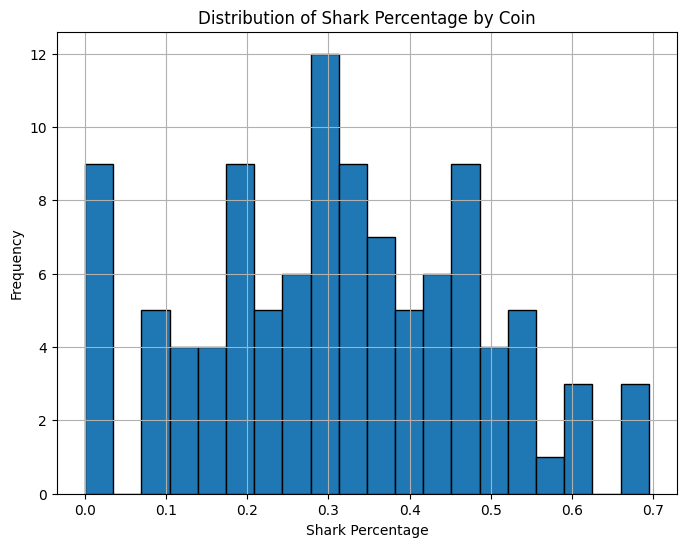

In [13]:
shark_column = 'is_shark'
# shark_column = 'is_returns_shark'

sharks = sharks_df.groupby('coin_id')[shark_column].sum()
wallets = sharks_df.groupby('coin_id').size()
shark_percentage_df = pd.DataFrame({
    'total_wallets': wallets,
    'shark_wallets': sharks
})
shark_percentage_df['shark_percentage'] = (shark_percentage_df['shark_wallets'] / shark_percentage_df['total_wallets'])

shark_percentage_df
import matplotlib.pyplot as plt

# Assuming 'shark_percentage_df' is available from the previous code

# Plot histogram of shark_percentage
plt.figure(figsize=(8, 6))
plt.hist(shark_percentage_df['shark_percentage'], bins=20, edgecolor='black')
plt.title('Distribution of Shark Percentage by Coin')
plt.xlabel('Shark Percentage')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [11]:
# count of all wallets for each coin
summary_df = sharks_df.groupby('coin_id').size().reset_index(name='all_wallets')

# count of shark wallets for each coin
sharks_count_df = sharks_df.groupby('coin_id')['is_shark'].sum().reset_index(name='shark_wallets')

# merge and calculate shark rate
summary_df = pd.merge(summary_df, sharks_count_df, on='coin_id', how='left')
summary_df['shark_rate'] = summary_df['shark_wallets']/summary_df['all_wallets']

summary_df



,coin_id,all_wallets,shark_wallets,shark_rate
0,0b9d343d-4e25-4d22-b49c-fa17509a0333,2205,964,0.437188208617
1,0db96a94-082b-4e13-a315-860850e9ff4f,924,482,0.521645021645
2,0e1c102e-2e7d-4aed-af2d-1526c2e0720a,500,57,0.114
3,0eedc336-a78e-4b25-957e-57117227ef78,6739,1723,0.255675916308
4,0f96fb26-1ee9-4232-ae0e-c768f38070b3,462,113,0.244588744589
...,...,...,...,...
101,eeccf0b6-aaaa-464c-a23e-f2fc9e73a350,915,278,0.303825136612
102,f0420cea-5dc1-42ac-b1bc-f6e48b7804f1,743,213,0.2866756393
103,f64ac466-300d-43d4-8c36-ef26a7a48977,63,0,0
104,f68b64ae-61d5-4dd6-b448-4ae9c754bd07,2278,710,0.31167690957


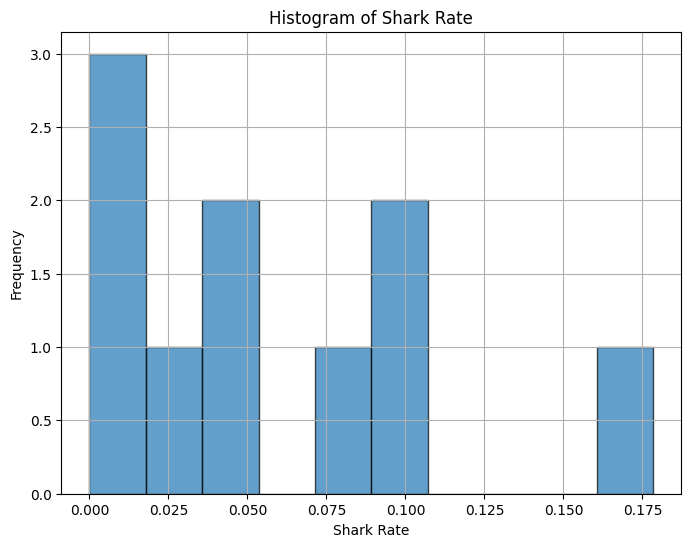

In [41]:
import matplotlib.pyplot as plt

# Example shark_rate data
shark_rate_data = [
    0.0479288369623, 0.098261526833, 0.0821052631579, 0.0388888888889, 0.021463757917,
    0, 0, 0.0952380952381, 0.178391959799, 0
]

# Create histogram of shark_rate
plt.figure(figsize=(8, 6))
plt.hist(shark_rate_data, bins=10, edgecolor='black', alpha=0.7)
plt.title('Histogram of Shark Rate')
plt.xlabel('Shark Rate')
plt.ylabel('Frequency')
plt.grid(True)

# Display the plot
plt.show()


In [12]:
# profits_df['profits_cumulative'].sum()
profits_df_old['profits_cumulative'].count()

3205467468437.944

In [14]:
profits_df['profits_cumulative'].sum()

3205467468437.944

In [16]:
profits_df.head()

,coin_id,wallet_address,date,net_transfers,balance,price,first_transfer_date,adjusted_net_transfers,profitability_change,profitability_cumulative
0,04a39c15-c70c-40ef-87a6-ff2850e7a5c9,0x00000000009726632680fb29d3f7a9734e3010e2,2024-06-29,52.6727892183,52.6727892183,0.0824039688436,2024-06-29,52.6727892183,0,0
1,04a39c15-c70c-40ef-87a6-ff2850e7a5c9,0x00000000009726632680fb29d3f7a9734e3010e2,2024-07-15,17.8010851795,70.4738743978,0.12681569103,2024-06-29,17.8010851795,2.33928928152,2.33928928152
2,04a39c15-c70c-40ef-87a6-ff2850e7a5c9,0x00000000009726632680fb29d3f7a9734e3010e2,2024-08-31,30.3633665636,100.837240961,0.122419792313,2024-06-29,30.3633665636,-0.309796014047,2.02949326748
3,04a39c15-c70c-40ef-87a6-ff2850e7a5c9,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-07-15,-3.63797880709e-12,-3.63797880709e-12,0.12681569103,2024-07-15,-3.63797880709e-12,0,0
4,04a39c15-c70c-40ef-87a6-ff2850e7a5c9,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-07-25,0.132674074648,0.132674074644,0.190726300024,2024-07-15,0.132674074648,-2.3250544107e-13,-2.3250544107e-13


count   17177272.00
mean         208.11
std        80014.31
min     -9946827.35
25%          -52.35
50%            0.73
75%          176.77
max      9943893.50
Name: profitability, dtype: float64


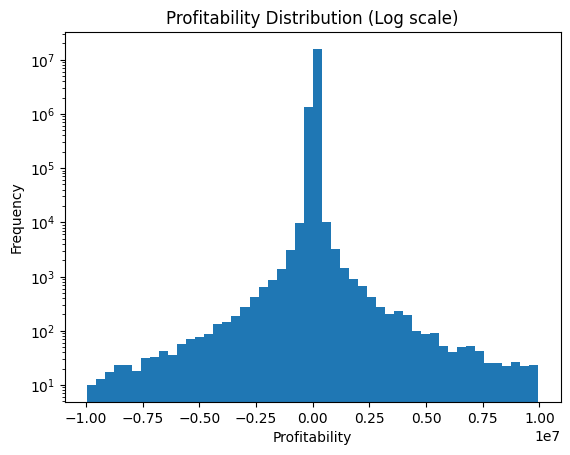

In [9]:

# Check the distribution of profitability values again
# print(profits_df['profitability'].describe())
print(profits_cleaned_df['profitability'].describe())

import matplotlib.pyplot as plt

# Plot distribution of profitability values
profits_cleaned_df['profitability'].plot(kind='hist', bins=50, logy=True)
plt.title('Profitability Distribution (Log scale)')
plt.xlabel('Profitability')
plt.show()

